# Introduction

Below I use the pyhdf module to read a single channel (channel 30) centered at 9.7 microns according to [the Modis channel listing](https://modis.gsfc.nasa.gov/about/specifications.php).  I plot the raw counts from that channel using the 
[matplotlib imshow](https://matplotlib.org/examples/images_contours_and_fields/image_demo.html) function to display the raw image


In [90]:
from pathlib import Path
from pyhdf.SD import SD, SDC
import pprint
import numpy as np
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy
import os
os.environ['PROJ_LIB'] = 'C:/Users/Pearl/Miniconda3/envs/e350/Library/share/basemap'
from mpl_toolkits.basemap import Basemap, cm
from modismeta_read import parseMeta
import pdb
import json
from pyresample import  SwathDefinition, kd_tree, geometry
from matplotlib import cm
from matplotlib.colors import Normalize
from IPython.display import Image,display
from pyresample import geometry
# from geometry import area_def_from_dict, get_image, plot_image

reading C:\Users\Pearl\Desktop\GeoPython\Dorian data files\MYD021KM.A2019241.1730.061.2019242151053.hdf
channel 30 is located at index 9
here are the modis channels in the emissive dataset 
[20. 21. 22. 23. 24. 25. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.]


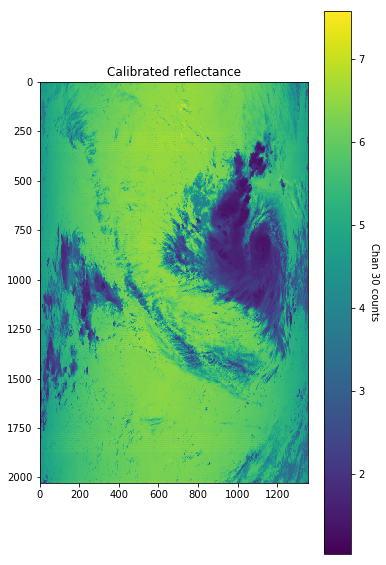

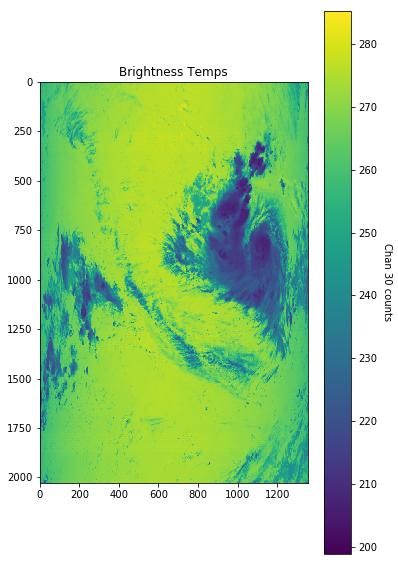

In [91]:
#Path.cwd finds the "current working directory"
this_dir=Path.cwd()
data_dir = this_dir / Path("Dorian data files")
hdf_files=list(data_dir.glob("MYD021KM*1730*053.hdf"))
# netcdf4_files=[str(i).split('\\')[-1] for i in all_data]

file_name = str(data_dir / Path(hdf_files[0]))
print(f'reading {file_name}')
the_file = SD(file_name, SDC.READ)

datasets_dict = the_file.datasets()
# for idx,sds in enumerate(datasets_dict.keys()):
#     print(idx,sds)
    
longwave_data = the_file.select('EV_1KM_Emissive') # select sds

longwave_bands = the_file.select('Band_1KM_Emissive')
band_nums=longwave_bands.get()
ch30_index=np.searchsorted(band_nums,30.)
ch30_index = int(ch30_index)
print(f'channel 30 is located at index {ch30_index}')
print(f'here are the modis channels in the emissive dataset \n{band_nums}')
ch30_data = longwave_data[ch30_index,:,:]

ch30_data = longwave_data[ch30_index,:,:]
scales=longwave_data.attributes()['radiance_scales']
offsets=longwave_data.attributes()['radiance_offsets']
ch30_scale=scales[ch30_index]
ch30_offset=offsets[ch30_index]
ch30_calibrated =(ch30_data - ch30_offset)*ch30_scale
ch30_calibrated

def radiance_invert(wavelength, Lstar):
    Estar = Lstar * np.pi
    
    c1 = 3.74*10E7 
    c2= 1.44*10E3 
    numer = c1/((wavelength)**5)  
    temp = c2/(wavelength*(np.log((numer/Estar) + 1)))
    
    return temp

t_data = radiance_invert(11.03, ch30_calibrated[:,:])

fig,ax = plt.subplots(1,1,figsize = (6,10))
CS=ax.imshow(ch30_calibrated)
cax=fig.colorbar(CS)
ax.set_title('Calibrated reflectance')
#
# add a label to the colorbar and flip it around 270 degrees
#
out=cax.ax.set_ylabel('Chan 30 counts')
out.set_verticalalignment('bottom')
out.set_rotation(270)



fig,ax = plt.subplots(1,1,figsize = (6,10))
CS=ax.imshow(t_data)
cax=fig.colorbar(CS)
ax.set_title('Brightness Temps')
#
# add a label to the colorbar and flip it around 270 degrees
#
out=cax.ax.set_ylabel('Chan 30 counts')
out.set_verticalalignment('bottom')
out.set_rotation(270)

In [92]:
# m = Basemap(projection='cyl', resolution='l', llcrnrlat=min_lat, urcrnrlat = max_lat, llcrnrlon=min_lon, urcrnrlon = max_lon)
# m.drawcoastlines(linewidth=0.5)
# m.drawparallels(np.arange(-90., 120., 2.), labels=[1, 0, 0, 0])
# m.drawmeridians(np.arange(-180., 181.,2.), labels=[0, 0, 0, 1])
# x, y = m(longitude, latitude)
# m.pcolormesh(x, y, ch30_calibrated*scale_factor, cmap=plt.cm.jet)
# cb = m.colorbar()


In [93]:
def get_proj_params(modis_file):
    """
    given a path to a Modis level1b file with a standard
    'CoreMetadata.0' atrribute, return proj4 parameters
    for use by cartopy or pyresample, assuming a laea projection
    and WGS84 datum
    
    Parameters
    ----------
    
    modis_file:  Path or str with path to hdf file
    
    Returns
    -------
    
    proj_params: dict
        dict with parameters for proj4
        
    """
    modis_dict=parseMeta(modis_file)
    import cartopy.crs as ccrs
    globe_w = ccrs.Globe(datum="WGS84",ellipse="WGS84")
    projection_w=ccrs.LambertAzimuthalEqualArea(central_latitude=modis_dict['lat_0'],
                    central_longitude= modis_dict['lon_0'],globe=globe_w)
    proj_params=projection_w.proj4_params
    return proj_params


def dump_image(image_array,metadata_dict,foldername,
              image_array_name='image'):
    """
    write an image plus mmetadata to a folder
    introduced in level2_cartopy_resample
    
    Parameters
    ----------
    
    image_array: ndarray
        the 2-d image to be saved
    
    foldername:  Path object or string
        the path to the folder that holds the image files
        
    image_array_name:  str
        the root name for the npz and json files
        i.e. image.npz and image.json
        
    Returns: None
       side effect -- an npz and a json file are written
    """
    image_file=Path(foldername) / Path(image_array_name)
    out_dict={image_array_name:image_array}
    np.savez(image_file,**out_dict)
    json_name = foldername / Path(image_array_name + '.json')
    with open(json_name,'w') as f:
        json.dump(metadata_dict,f,indent=4)
    print(f"\ndumping {image_file}\n and {json_name}\n")

def make_projection(proj_params):
    """
    turn a set of proj4 parameters into a cartopy laea projection

    introduced in read_resample.ipynb
    
    Parameters
    ----------
    
    proj_params: dict
       dictionary with parameters lat_0, lon_0 datum and ellps
       
    Returns
    -------
    
    cartopy projection object
    
    """
    import cartopy.crs as ccrs
    globe_w = ccrs.Globe(datum=proj_params["datum"],ellipse=proj_params['ellps'])
    projection_w=ccrs.LambertAzimuthalEqualArea(central_latitude=float(proj_params['lat_0']),
                    central_longitude= float(proj_params['lon_0']),globe=globe_w)
    return projection_w


def area_def_to_dict(area_def):
    """
    given an area_def, save it as a dictionary

    introduced in level2_cartopy_resample.ipynb
    
    Parameters
    ----------
    
    area_def: pyresample area_def object
         
    Returns
    -------
    
    out_dict: dict containing
       area_def dictionary
         
    """
    keys=['area_id','proj_id','name','proj_dict','x_size','y_size','area_extent']
    area_dict={key:getattr(area_def,key) for key in keys}
    area_dict['proj_id']=area_dict['area_id']
    return area_dict


def area_def_from_dict(area_def_dict):
    """
    given an dictionary produced by dump_area_def
    return a pyresample area_def

    introduced in level2_cartopy_plot
    
    Parameters
    ----------
    
    area_def_dict: dict
        dictionary containing area_def parameters
        
    Returns
    -------
    
    pyresample area_def object

    """
    keys=['area_id','proj_id','name','proj_dict','x_size','y_size','area_extent']    
    arglist=[area_def_dict[key] for key in keys]
    area_def=geometry.AreaDefinition(*arglist)
    return area_def

def get_image(foldername,image_array_name):
    """
    write an image plus mmetadata to a folder under a301.map_dir

    introduced in level2_cartopy_plot
    
    Parameters
    ----------

    foldername:  Path object or string
        the path to the folder that holds the image files
        
    image_array_name:  str
        the root name for the npz and json files
        i.e. image.npz and image.json
        
    Returns: 
    
    tumple: contains (image_array, area_def)

    where image_array: ndarray with the image
    
          area_def:  pyresample area_def for image
    """
    image_file=Path(foldername) / Path(image_array_name + '.npz')
    image_array = np.load(image_file)[image_array_name]
    json_file = foldername / Path(image_array_name + '.json')
    with open(json_file,'r') as f:
        meta_dict=json.load(f)
    area_def = area_def_from_dict(meta_dict['area_def'])
    return image_array, area_def

def plot_image(resampled_image,area_def,vmin=0.,vmax=4.,palette='plasma'):
    """
    Make a cartopy plot of an image 

    introduced in level2_cartopy_plot.ipynb
    
    Parameters
    ----------
    
    resampled_image: ndarray
       2-dimensional image that has be resampled onto an xy grid
       
    area_def:  pyresample area_def objet
       the area_def that was used by pyresample
       
    vmin,vmax:  floats
        upper and lower limits for the color map
        
    palette: str or matplotlib colormap
        colormap to use for plot
        
    Returns
    -------
    
    fig,ax: matmplotlib figure and axis objects
    """
    if isinstance(palette,str):
        pal = plt.get_cmap(palette)
    else:
        pal = palette
    pal.set_bad('0.75') #75% grey for out-of-map cells
    pal.set_over('r')  #color cells > vmax red
    pal.set_under('k')  #color cells < vmin black
    
    from matplotlib.colors import Normalize
    the_norm=Normalize(vmin=vmin,vmax=vmax,clip=False)
    crs = area_def.to_cartopy_crs()
    fig, ax = plt.subplots(1, 1, figsize=(10,10),
                              subplot_kw={'projection': crs})
    ax.gridlines(linewidth=2)
    ax.add_feature(cartopy.feature.GSHHSFeature(scale='coarse', levels=[1,2,3]));
    ax.set_extent(crs.bounds,crs)
    cs=ax.imshow(resampled_image, transform=crs, extent=crs.bounds, 
                 origin='upper',alpha=0.8,cmap=pal,norm=the_norm)
    fig.colorbar(cs,extend='both')
    return fig, ax    
